In [46]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

In [47]:
def read_df(tags, samples):
    dfs = []
    if isinstance(tags, list):
        tags = {t: t for t in tags}
    for short_tag, full_tag in tags.items():
        for sample in range(samples):
            try:
                df = pd.read_json(f"outputs/{full_tag}_{sample}/logs.json")
                df["tag"] = short_tag
                df["sample"] = sample
                df["epoch"] = df.index
                df["train_reg"] = df["train_loss"] - df["train_ce"]
                df["eval_reg"] = df["eval_loss"] - df["eval_ce"]
                dfs.append(df)
            except:
                pass
    return pd.concat(dfs)

def agg_df(df_src, s):
    df_list = []
    for c in s:
        df = df_src.copy()
        df["tag"] = df["tag"].apply(lambda s: f"p{c}" if c in s else f"n{c}")
        df = df.groupby(["tag", "epoch"]).mean().reset_index().set_index("epoch")
        df_list.append(df)
    return pd.concat(df_list)
def outer(x):
    return x.unsqueeze(-1) * x.unsqueeze(-2)

def std(m1, m2):
    return (m2.diagonal() - m1.square()).clip(min=0).sqrt()

def cov(m1, m2):
    return m2 - outer(m1)

def corr(m1, m2):
    return cov(m1, m2) / outer(std(m1, m2))

def lin_map(x, s):
    return x.clamp(-s, s), (-s, s)

def inf_map(x, s):
    a = np.pi / 2
    return (x / s * a).arctan() / a, (-1, 1)

def read_state(state, i, sign):
    sym = "n" if sign else "s"
    s0 = state[f"{i}.train_agg.s0"]
    s1 = state[f"{i}.train_agg.{sym}1"]
    s2 = state[f"{i}.train_agg.{sym}2"]
    return s1 / s0, s2 / s0

def read_weight(state, i, flip):
    w = state[f"{i}.weight"]
    if flip:
        w = w.T
    return w.mean(0), w.T @ w

In [58]:
#tags = [f"schemes/{s}_{l}" for s in ("none", "base", "mean", "cov-mc", "cov-quad") for l in ("all",)]
#tags = [f"cov/cov_{l}_b{b}_o{o}_c{c}" for l in ("mc",) for b in (0, 1) for o in (0, 1, 2) for c in (1,)]
#tags = [f"cov/cov_mc_b0_o2_c0{s}" for s in ("", "_lsg", "_wsg", "_psg")]
#tags = ["cov/cov_mc_b0_o2_c0"] + [f"cov/cov_mc_b0_o2_c0{s}_l2" 
#    for s in ("", "_xsg", "_wsg", "_psg", "_lsg", "_gsg", "_hsg")]
#tags = {l: f"cov/cov_mc_b0_o2_c0_{l}" for l in ("l", "l1", "l2", "l3", "l123")}
tags = {f"{l}": f"cov/cov_mc_b0_o2_c0_{l}" for l in ("l", "l1", "l2", "l3", "l123")}
#tags = [f"hpo/mean_{s}_{l}" for s in ("s0.0", "s0.5") for l in ("l5e-4", "l1e-3", "l2e-3", "l5e-3", "l1e-2")]

samples = 10
epochs = (50,)
tags_epochs = [(tag, epoch) for tag in tags for epoch in epochs]
layers = [f"layer {i+1}" for i in range(3)]

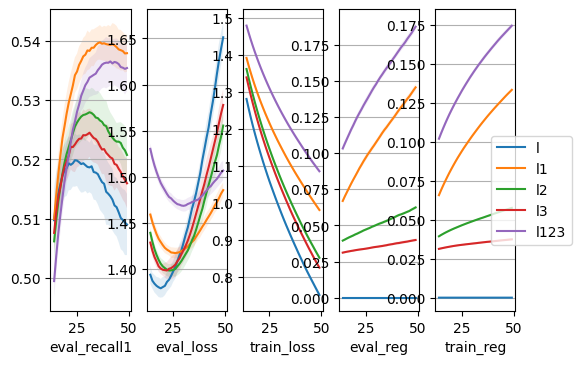

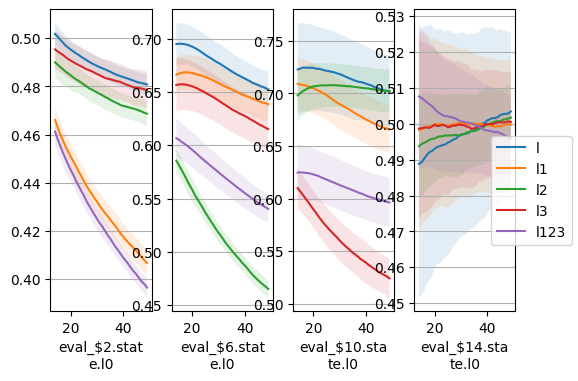

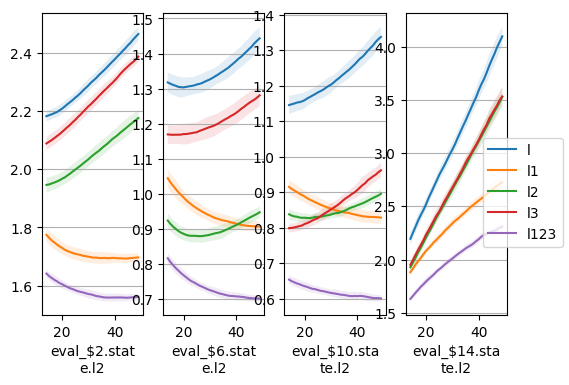

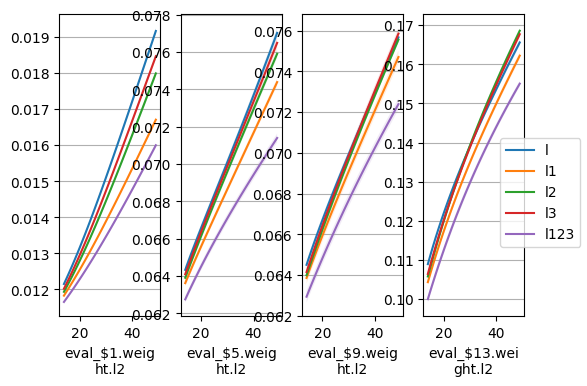

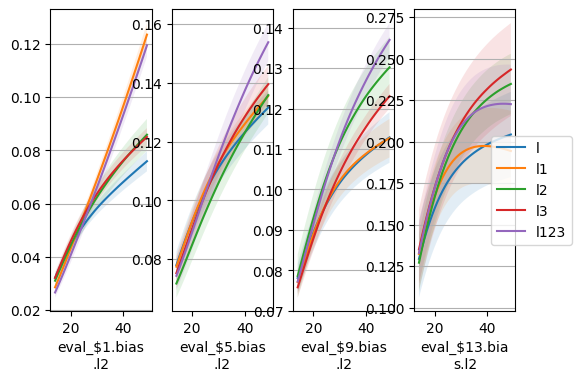

In [59]:
def rowplots(df, labels, rolling=5, start=15, stop=50, sharex=True, sharey=False):
    fig, axes = plt.subplots(
        1, len(labels),
        sharex=sharex, sharey=sharey, 
        facecolor="w", dpi=100)
    if len(labels) == 1:
        axes = [axes]
    df = df[(df.index >= start-rolling)&(df.index < stop)]
    df_mean = df.groupby(["tag", "epoch"], sort=False).mean().reset_index().set_index("epoch").groupby("tag", sort=False)
    df_var = df.groupby(["tag", "epoch"], sort=False).var().reset_index().set_index("epoch").groupby("tag", sort=False)
    for ax, label in zip(axes, labels):
        ax.set_xlabel(f"{label[:12]}\n{label[12:]}")
        ax.grid(axis="y")
        for (tag, mean), (_, var) in zip(df_mean[label], df_var[label]):
            if rolling > 0:
                mean = mean.rolling(rolling).mean()
                var = var.rolling(rolling).mean()
            std = np.sqrt(var)
            ax.plot(mean, label=tag)
            ax.fill_between(mean.index, mean-std, mean+std, alpha=0.125)
        #ax.set_ylim(bottom=0)
    fig.legend(*axes[0].get_legend_handles_labels(), "right")

df = read_df(tags, samples)
rowplots(df, ["eval_recall1", "eval_loss", "train_loss", "eval_reg", "train_reg"])
rowplots(df, [f"eval_${i*4+2}.state.l0" for i in range(4)])
rowplots(df, [f"eval_${i*4+2}.state.l2" for i in range(4)])
rowplots(df, [f"eval_${i*4+1}.weight.l2" for i in range(4)])
rowplots(df, [f"eval_${i*4+1}.bias.l2" for i in range(4)])
None

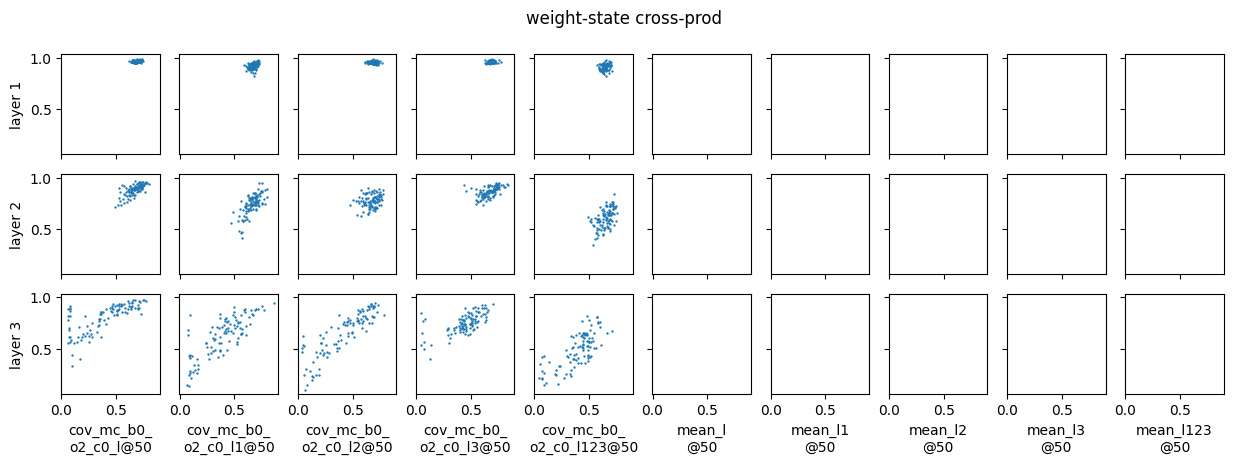

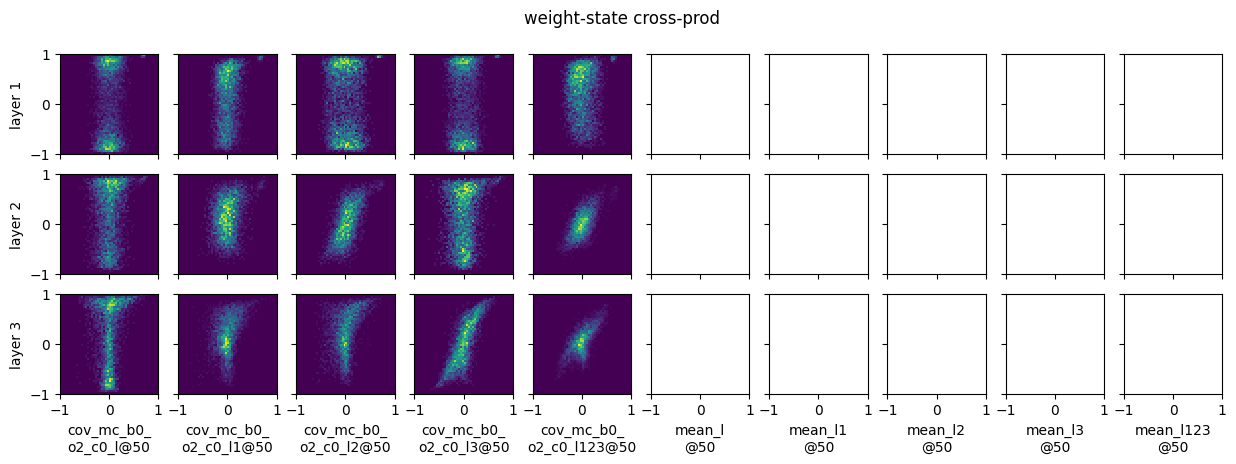

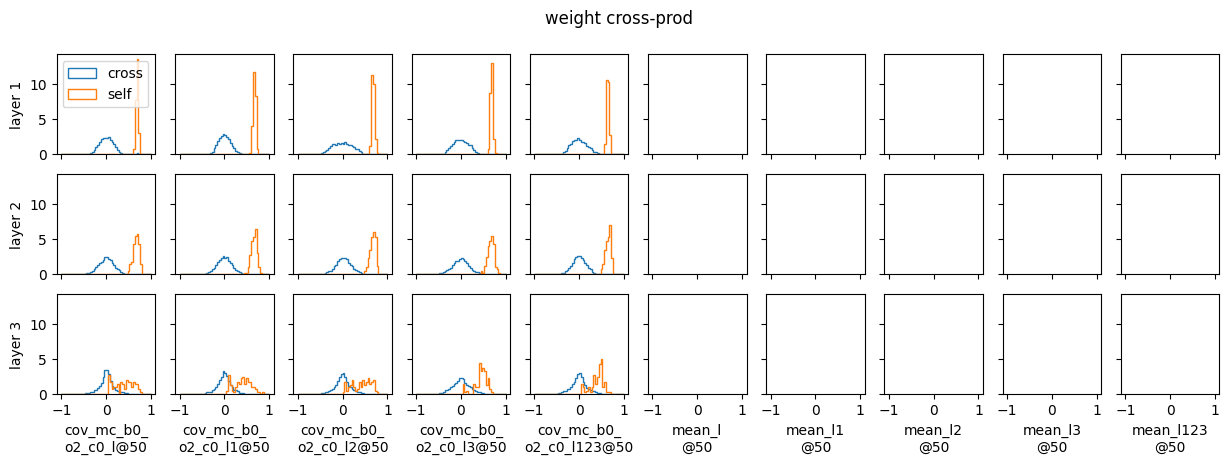

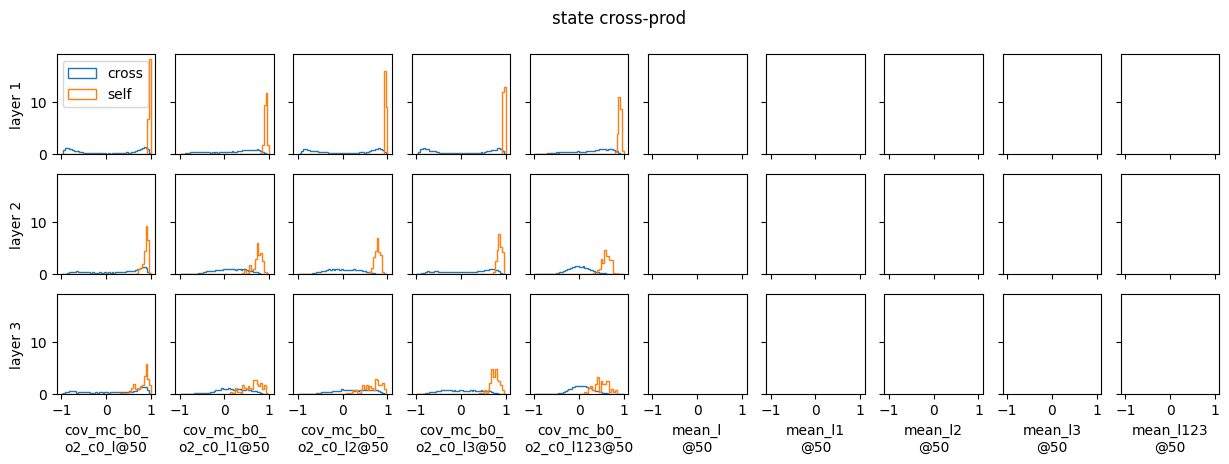

In [5]:
def gridplot(title, xlabels, ylabels):
    nrows, ncols = len(ylabels), len(xlabels)
    fig, axes = plt.subplots(
        nrows, ncols, sharex=True, sharey=True, 
        figsize=(ncols*1.5, nrows*1.5), dpi=100, facecolor="w")
    fig.suptitle(title)
    for i in range(ncols):
        axes[nrows-1][i].set_xlabel(xlabels[i])
    for i in range(nrows):
        axes[i][0].set_ylabel(ylabels[i])
    return axes

def hist2d_plot(ax1, ax2, x, y, range, bins):
    ax2.hist2d(x.flatten().numpy(), y.flatten().numpy(), range=range, bins=bins, density=True)
    ax1.scatter(x.diagonal().numpy(), y.diagonal().numpy(), s=0.5)

def hist1d_plot(ax, x, range, bins):
    ax.hist(x.flatten().numpy(), label="cross", range=range, bins=bins, histtype="step", density=True)
    ax.hist(x.diagonal().numpy(), label="self", range=range, bins=bins, histtype="step", density=True)

def setplot(group, tags_epochs, layers, term, sign, scales, mapping, fn):
    xlabels = [f"{tag[:10]}\n{tag[10:]}@{epoch}" for tag, epoch in tags_epochs]
    ax_xy1 = gridplot(f"weight-state {term}", xlabels, layers)
    ax_xy2 = gridplot(f"weight-state {term}", xlabels, layers)
    ax_x = gridplot(f"weight {term}", xlabels, layers)
    ax_y = gridplot(f"state {term}", xlabels, layers)
    for i, (tag, epoch) in enumerate(tags_epochs):
        path = f"outputs/{group}/{tag}_0/checkpoint-{epoch}.pt"
        try:
            state = torch.load(path, map_location="cpu")
        except Exception:
            continue
        for j, layer in enumerate(layers):
            w_m1, w_m2 = read_weight(state["model"], j*4+5, False)
            s_m1, s_m2 = read_state(state["model"], j*4+2, sign)
            x, x_range = mapping(fn(w_m1, w_m2), scales[0])
            y, y_range = mapping(fn(s_m1, s_m2), scales[1])
            x_bins, y_bins = 50, 50
            hist2d_plot(ax_xy1[j][i], ax_xy2[j][i], x, y, (x_range, y_range), (x_bins, y_bins))
            hist1d_plot(ax_x[j][i], x, x_range, x_bins)
            hist1d_plot(ax_y[j][i], y, y_range, y_bins)
    ax_x[0][0].legend()
    ax_y[0][0].legend()

term, sign, scales, mapping, fn = "cross-prod", False, (.5, .5), inf_map, lambda m1, m2: m2
#term, sign, scales, mapping, fn = "covariance", False, (.5, .5), inf_map, cov
#term, sign, scales, mapping, fn = "correlation", False, (1., 1.), lin_map, corr
setplot(group, tags_epochs, layers, term, sign, scales, mapping, fn)